In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot

In [79]:
import os
plots_results_path = './results'
if not os.path.exists(plots_results_path):
    os.mkdir(plots_results_path)

In [80]:
actions = pd.read_json('../exported/actions.json')
actions['_id'] = actions['_id'].apply(lambda x: x['$oid'])
actions['time'] = actions['time'].apply(lambda x: x['$date'])
actions['time'] = pd.to_datetime(actions['time'])


In [81]:
users = pd.read_json('../exported/users.json')
users['_id'] = users['_id'].apply(lambda x: x['$oid'])


In [82]:
actions['user_id'] = actions['user'].map(
    lambda userObject: userObject["$oid"], na_action='ignore')


In [83]:
actions = actions.merge(users, how='left', left_on='user_id', right_on='_id')


In [84]:
confessions = pd.read_json('../exported/confessions.json')


In [85]:
confessions['createdAt'] = confessions['createdAt'].apply(lambda x: x['$date'])
confessions['createdAt'] = pd.to_datetime(confessions['createdAt'])


In [86]:
confessions['_id'] = confessions['_id'].apply(lambda x: x['$oid'])


In [87]:
confessions['actions'] = confessions['actions'].apply(
    lambda x: pd.DataFrame(x))


In [88]:
confessions['actions'] = confessions['actions'].apply(
    lambda actions_df: actions_df.merge(actions, how='left', left_on='$oid', right_on='_id_x'))


In [89]:
moderator_actions_count = actions[['_id_x', 'username']].groupby(
    "username").count().reset_index()


In [90]:
moderator_actions_count = moderator_actions_count.sort_values(
    '_id_x', ascending=False)


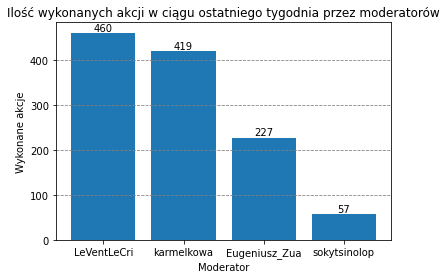

In [91]:
fig, ax = plot.subplots()
ax.grid(color='gray', linestyle='dashed', axis='y')
bars = ax.bar(moderator_actions_count['username'],
         height=moderator_actions_count['_id_x'])
ax.bar_label(bars)
plot.ylabel('Wykonane akcje')
plot.xlabel('Moderator')
plot.title('Ilość wykonanych akcji w ciągu ostatniego tygodnia przez moderatorów')

plot.savefig(f'{plots_results_path}/top_mods.png')
plot.show()


In [92]:
# maybe filter out tags removed by moderator? where tag[1] == 0
confessions['tag_list'] = confessions.apply(
    lambda x: [tag[0] for tag in x['tags']], axis=1)


In [93]:
import string
tag_occurences_list = confessions['tag_list'].explode()
unique, counts = np.unique(tag_occurences_list, return_counts=True)
tag_occurences = list(zip(unique, counts))
tag_occurences = sorted(tag_occurences, key=lambda x: x[1])


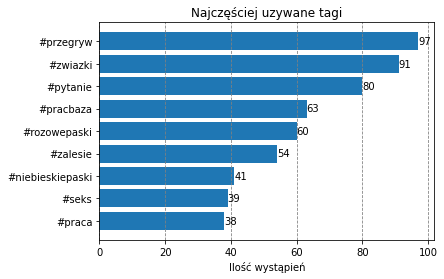

In [94]:
# TODO: https://stackoverflow.com/a/68107816/4183352
top_tags = tag_occurences[-10:]  # get most used tags
top_tags = top_tags[:-1]  # remove most used tag (#anonimowemirkowyznania)
tag_labes = [x[0] for x in top_tags]
tag_occurences_values = [x[1] for x in top_tags]

fix,ax = plot.subplots()
ax.grid(color='gray', linestyle='dashed', axis='x')

bars = ax.barh(tag_labes, width=tag_occurences_values)
ax.bar_label(bars)
plot.title('Najczęściej uzywane tagi')
plot.xlabel('Ilość wystąpień')

plot.savefig(f'{plots_results_path}/top_tags.png')
plot.show()


In [95]:
def get_first_mod_action(actions_df):
    # find first index of action of type accept / decline
    idx = actions_df[(actions_df['type'] == 1) | (
        actions_df['type'] == 2)].first_valid_index()
    return actions_df.iloc[[idx]] if idx else None


confessions['1st_mod_action'] = confessions['actions'].map(
    get_first_mod_action).map(lambda x: x['time'].iloc[0], na_action='ignore')


In [96]:
confessions['reaction_time'] = confessions['1st_mod_action'].subtract(
    confessions['createdAt'])


In [97]:
hours_to_react = confessions['reaction_time'].map(lambda x: x.total_seconds() / (60*60))
hours_to_react = hours_to_react[~np.isnan(hours_to_react)]

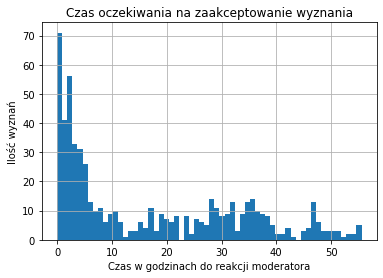

In [98]:
plot.hist(hours_to_react, 60)
plot.xlabel('Czas w godzinach do reakcji moderatora')
plot.ylabel('Ilość wyznań')
plot.title('Czas oczekiwania na zaakceptowanie wyznania')
plot.grid(True)

plot.savefig(f'{plots_results_path}/reaction_time_histogram.png')
plot.show()

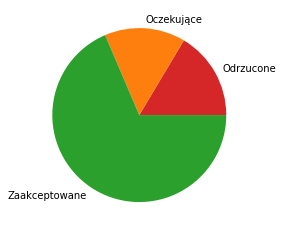

In [99]:
data = confessions[['_id', 'status']].groupby('status')
statuses = list(data.groups.keys())
status_label_map = {
    -1: 'Odrzucone',
    0: 'Oczekujące',
    1: 'Zaakceptowane'
}
status_color_map = {
    -1: 'tab:red',
    0: 'tab:orange',
    1: 'tab:green'
}
labels = [status_label_map[status] for status in statuses]
colors = [status_color_map[status] for status in statuses]
plot.pie(data.count()['_id'], labels=labels, colors=colors)

plot.savefig(f'{plots_results_path}/statuses_pie.png')
plot.show()

In [100]:
confessions_added = confessions['_id'].count()
confessions_accepted = confessions[confessions['status']==1]['_id'].count()
confessions_declined = confessions[confessions['status']==-1]['_id'].count()
avg_reaction_time = confessions['reaction_time'].mean()
confessions_added, confessions_accepted, confessions_declined, avg_reaction_time

(700, 480, 115, '0 days 16:36:38.439843697')

In [ ]:
f = open(f"./results/result_text.txt", "w")
since = os.getenv('SINCE')
until = os.getenv('UNTIL')
f.write(f"""
#anonimowemirkowyznaniastatystyki
Statystyki z ostatniego tygodnia ({since}, {until}):
Dodane wyznania: {confessions_added}
Zaakceptowane wyznania: {confessions_accepted}
Odrzucone wyznania: {confessions_declined}

średni czas oczekiwania na dodanie wydania: {avg_reaction_time}
""")
f.close()